<a href="https://colab.research.google.com/github/GKS07/Computer_Vision/blob/main/Food_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Image Classification

Food Image Classification Dataset:

*   The dataset contains 24K unique images.
*   Focuses on 35 varieties of both Indian and Western appetizers


# Downloading the  data

In [2]:
# uploading the kaggle jason file
from google.colab import files
files.upload()

# copying the kaggle file

!mkdir ~/.kaggle # nmaking the folder

! cp kaggle.json ~/.kaggle/  #copy the file

#changing the permission.
! chmod 600 ~/.kaggle/kaggle.json


# downloading the data from kaggle

!kaggle datasets download -d harishkumardatalab/food-image-classification-dataset

# making the folder
!mkdir food


Saving kaggle.json to kaggle.json
 99% 1.67G/1.68G [00:19<00:00, 46.2MB/s]
100% 1.68G/1.68G [00:19<00:00, 93.0MB/s]


In [ ]:
#unzipping the data

!unzip food-image-classification-dataset.zip -d food

In [4]:
# importing teh libraries

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg
%matplotlib inline
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout,Flatten, Dense, Rescaling
from tensorflow.keras.activations import relu, softmax
import seaborn as sns
import keras
from tensorflow.keras.applications import VGG19


import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")


In [5]:
#folder_path of the image

img_path = '/content/food/Food Classification dataset'


# defining some parameter

batch_size = 62
img_size = 300

#generating data
img_data_generator = ImageDataGenerator(shear_range = 0.2,
                                        rescale = 1./255,
                                        zoom_range = 0.2,
                                        horizontal_flip = True,
                                        vertical_flip = True,
                                        #fill_mode = 'nearest',
                                        #rotation_range = 20,
                                        width_shift_range = 0.2,
                                        height_shift_range = 0.2,
                                        validation_split = 0.2)

#generating a training data
training_data = img_data_generator.flow_from_directory('/content/food/Food Classification dataset',
                                                       target_size = (img_size, img_size),
                                                       color_mode = 'rgb',
                                                       batch_size = batch_size,
                                                       class_mode = 'categorical',
                                                       shuffle = True,
                                                       seed = 123,
                                                       subset = 'training')

#generating the validation data

validation_data = img_data_generator.flow_from_directory('/content/food/Food Classification dataset',
                                                         target_size = (img_size, img_size),
                                                         color_mode = 'rgb',
                                                         batch_size = batch_size,
                                                         class_mode = 'categorical',
                                                         subset = 'validation')


Found 19108 images belonging to 34 classes.
Found 4765 images belonging to 34 classes.


In [6]:
#name of the foods

CLASSES  = [x for x in training_data.class_indices ]

In [7]:
# defining the function to display the images of food

def display_one_food(image, title, subplot, color):
  plt.subplot(subplot)
  plt.axis('off')
  plt.imshow(image)
  plt.title(title, fontsize=16, color=color)

# plotting the 9 images
def display_nine_foods(images, titles, title_colors=None):
  subplot = 331
  plt.figure(figsize=(20,15))
  for i in range(9):
    color = 'black' if title_colors is None else title_colors[i]
    display_one_food(images[i], titles[i], 331+i, color)
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

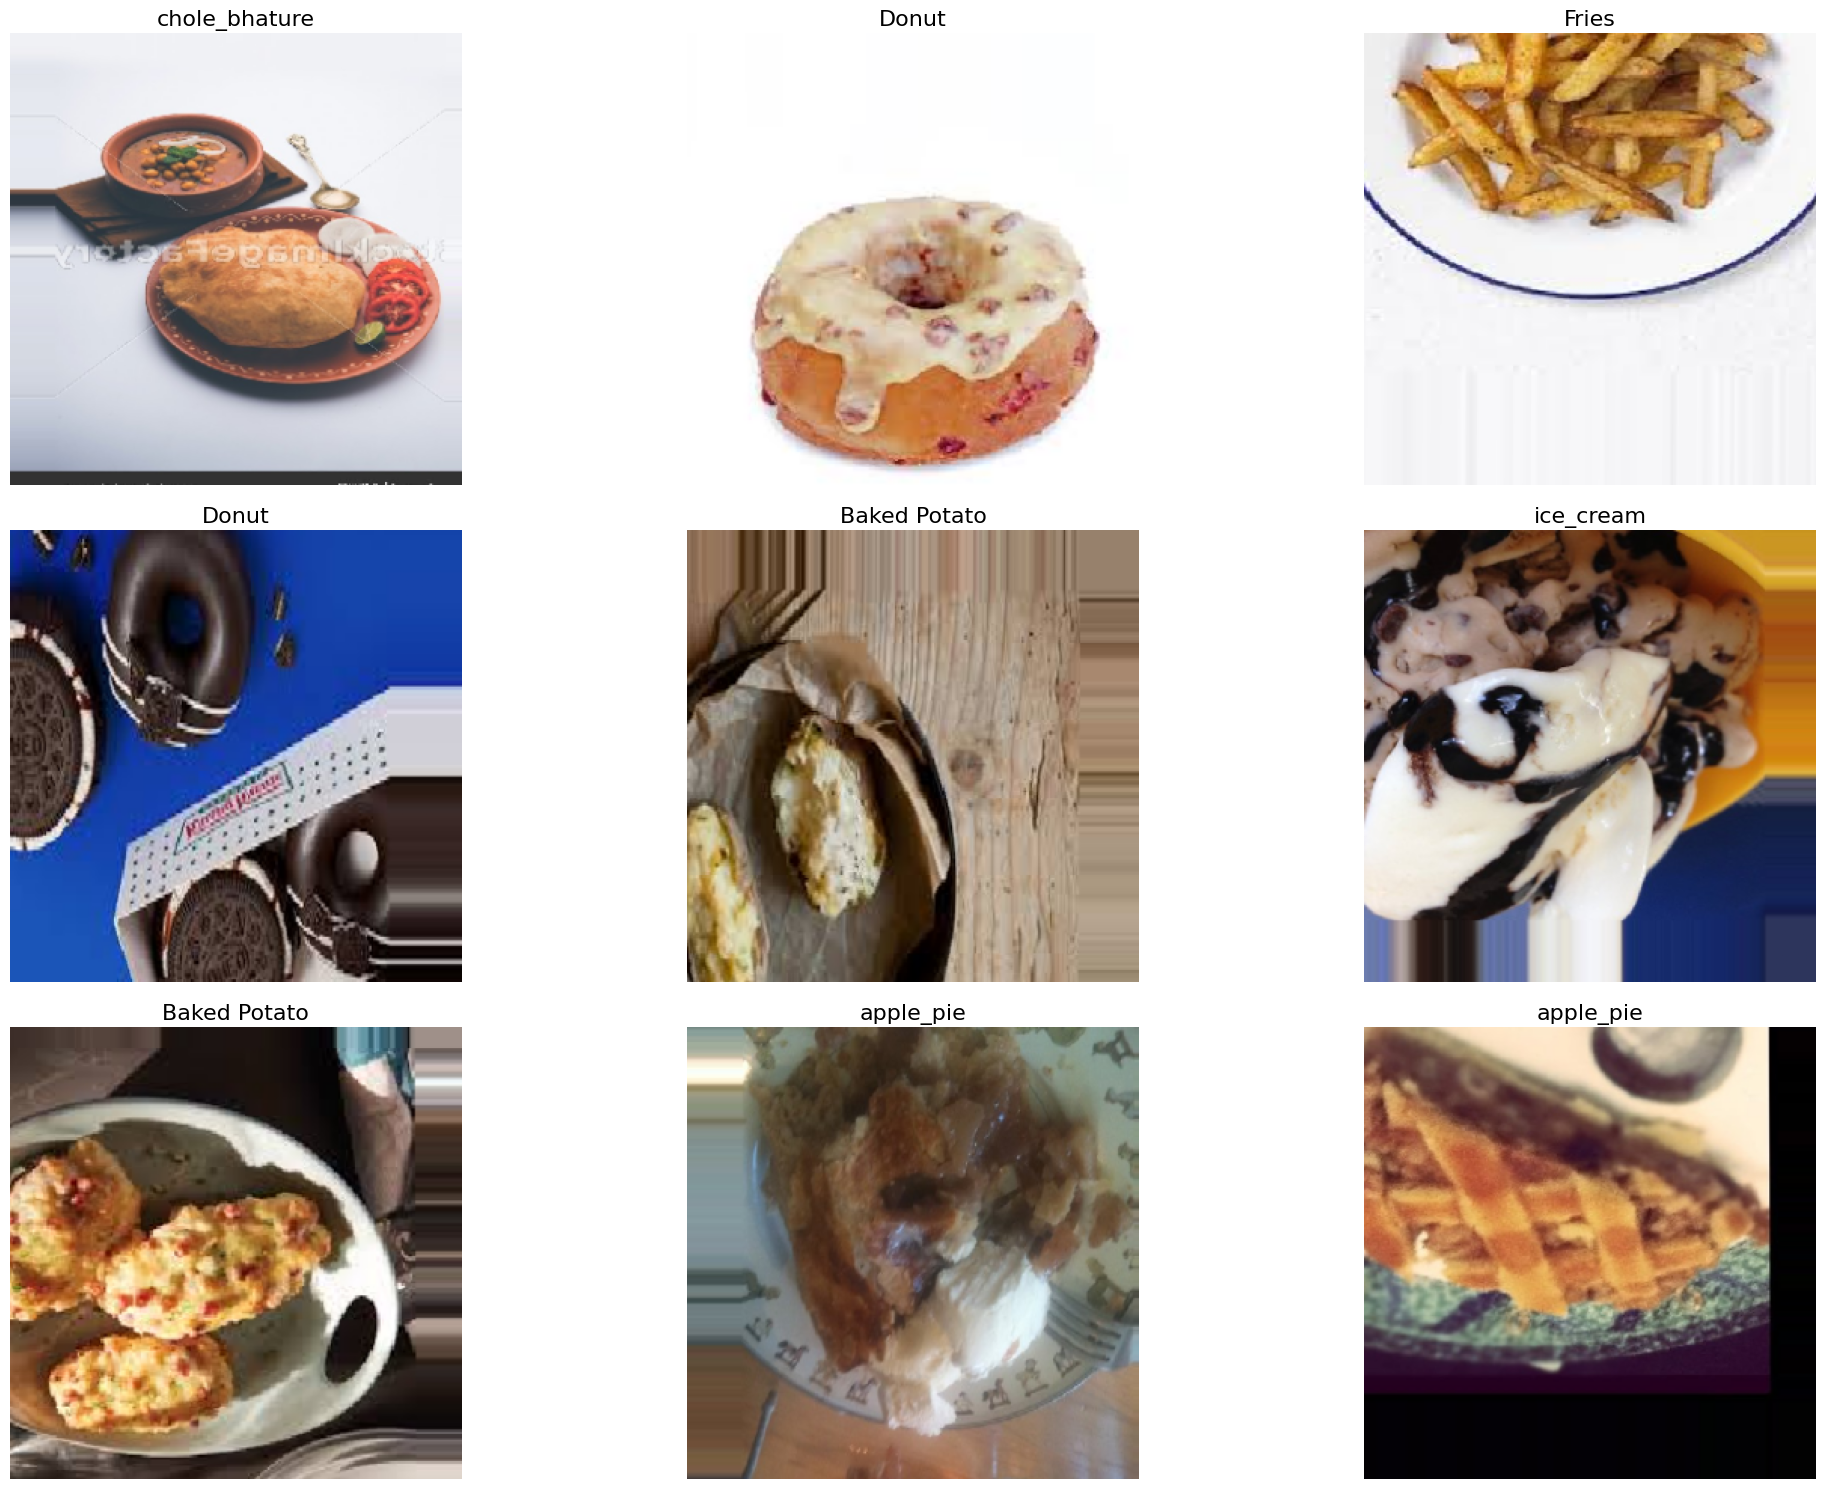

In [8]:
# displaying images from training data.
images, classes = next(training_data)
class_idxs = np.argmax(classes, axis=-1) # transform from one-hot array to class number
labels = [CLASSES[idx] for idx in class_idxs]
display_nine_foods(images, labels)

# Creating model basedmon VGG19

In [9]:
with tf.device('/device:GPU:0'):
  def create_model():
    pretrained_model = VGG19(input_shape = training_data.image_shape, include_top = False, weights = 'imagenet')

    #freezing some layers of the base model

    pretrained_model.trainable = True
    for layer in pretrained_model.layers[:17]:
      layer.trainable = False


    x = layers.GlobalMaxPooling2D()(pretrained_model.output)

    #x = Dense(312, activation = 'relu')(x)

    #x = Dropout(0.2)(x)

    #x = Dense(150, activation = 'relu')(x)

    outputs = Dense(34, activation = 'softmax')(x)

    model = keras.Model(pretrained_model.input, outputs)

    model.compile(
      optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
      loss = 'categorical_crossentropy',
      metrics = ['accuracy']
    )
    return model

  vgg19_model = create_model()
  vgg19_model.summary()



  epochs = 10


  # for early stopping
  callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
  vgg19_history = vgg19_model.fit(training_data,
                    validation_data = validation_data,
                    callbacks=[callback],
                    verbose = 1,
                    epochs = epochs
                    )

  final_accuracy = vgg19_history.history["val_accuracy"][-5:]
  print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

80134624/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                              

In [11]:
#displaying the training curves:

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])


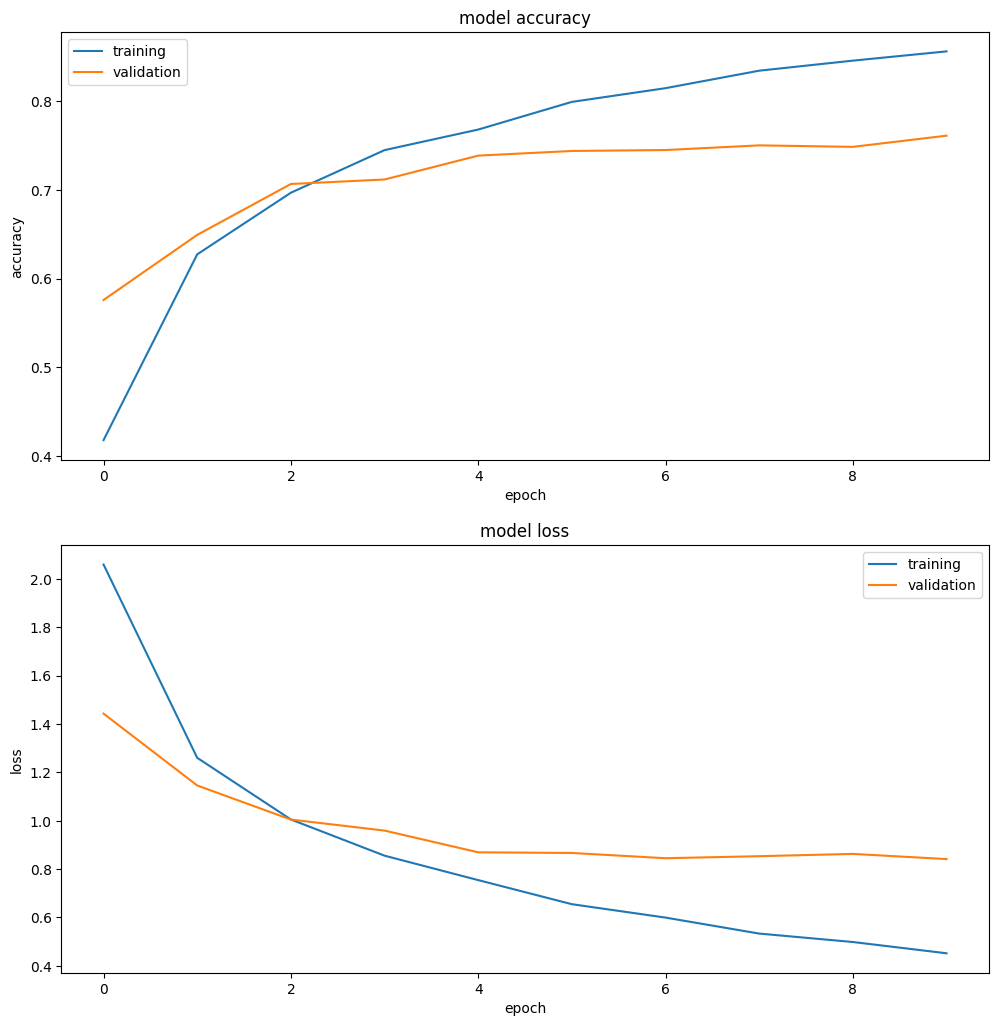

In [12]:
plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(vgg19_history.history['accuracy'], vgg19_history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(vgg19_history.history['loss'], vgg19_history.history['val_loss'], 'loss', 212)

In [15]:
#defining the function to get the predicted label

def food_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
  class_idx = np.argmax(label, axis=-1)
  prediction_idx = np.argmax(prediction, axis=-1)
  if class_idx == prediction_idx:
    return f'{CLASSES[prediction_idx]} [correct]', 'green'
  else:
    return f'{CLASSES[prediction_idx]} [incorrect, should be {CLASSES[class_idx]}]', 'red'

def get_titles(images, labels, model):
  predictions = model.predict(images)
  titles, colors = [], []
  for label, prediction in zip(classes, predictions):
    title, color = food_title(label, prediction)
    titles.append(title)
    colors.append(color)
  return titles, colors


2/2 [==============================] - 0s 299ms/step


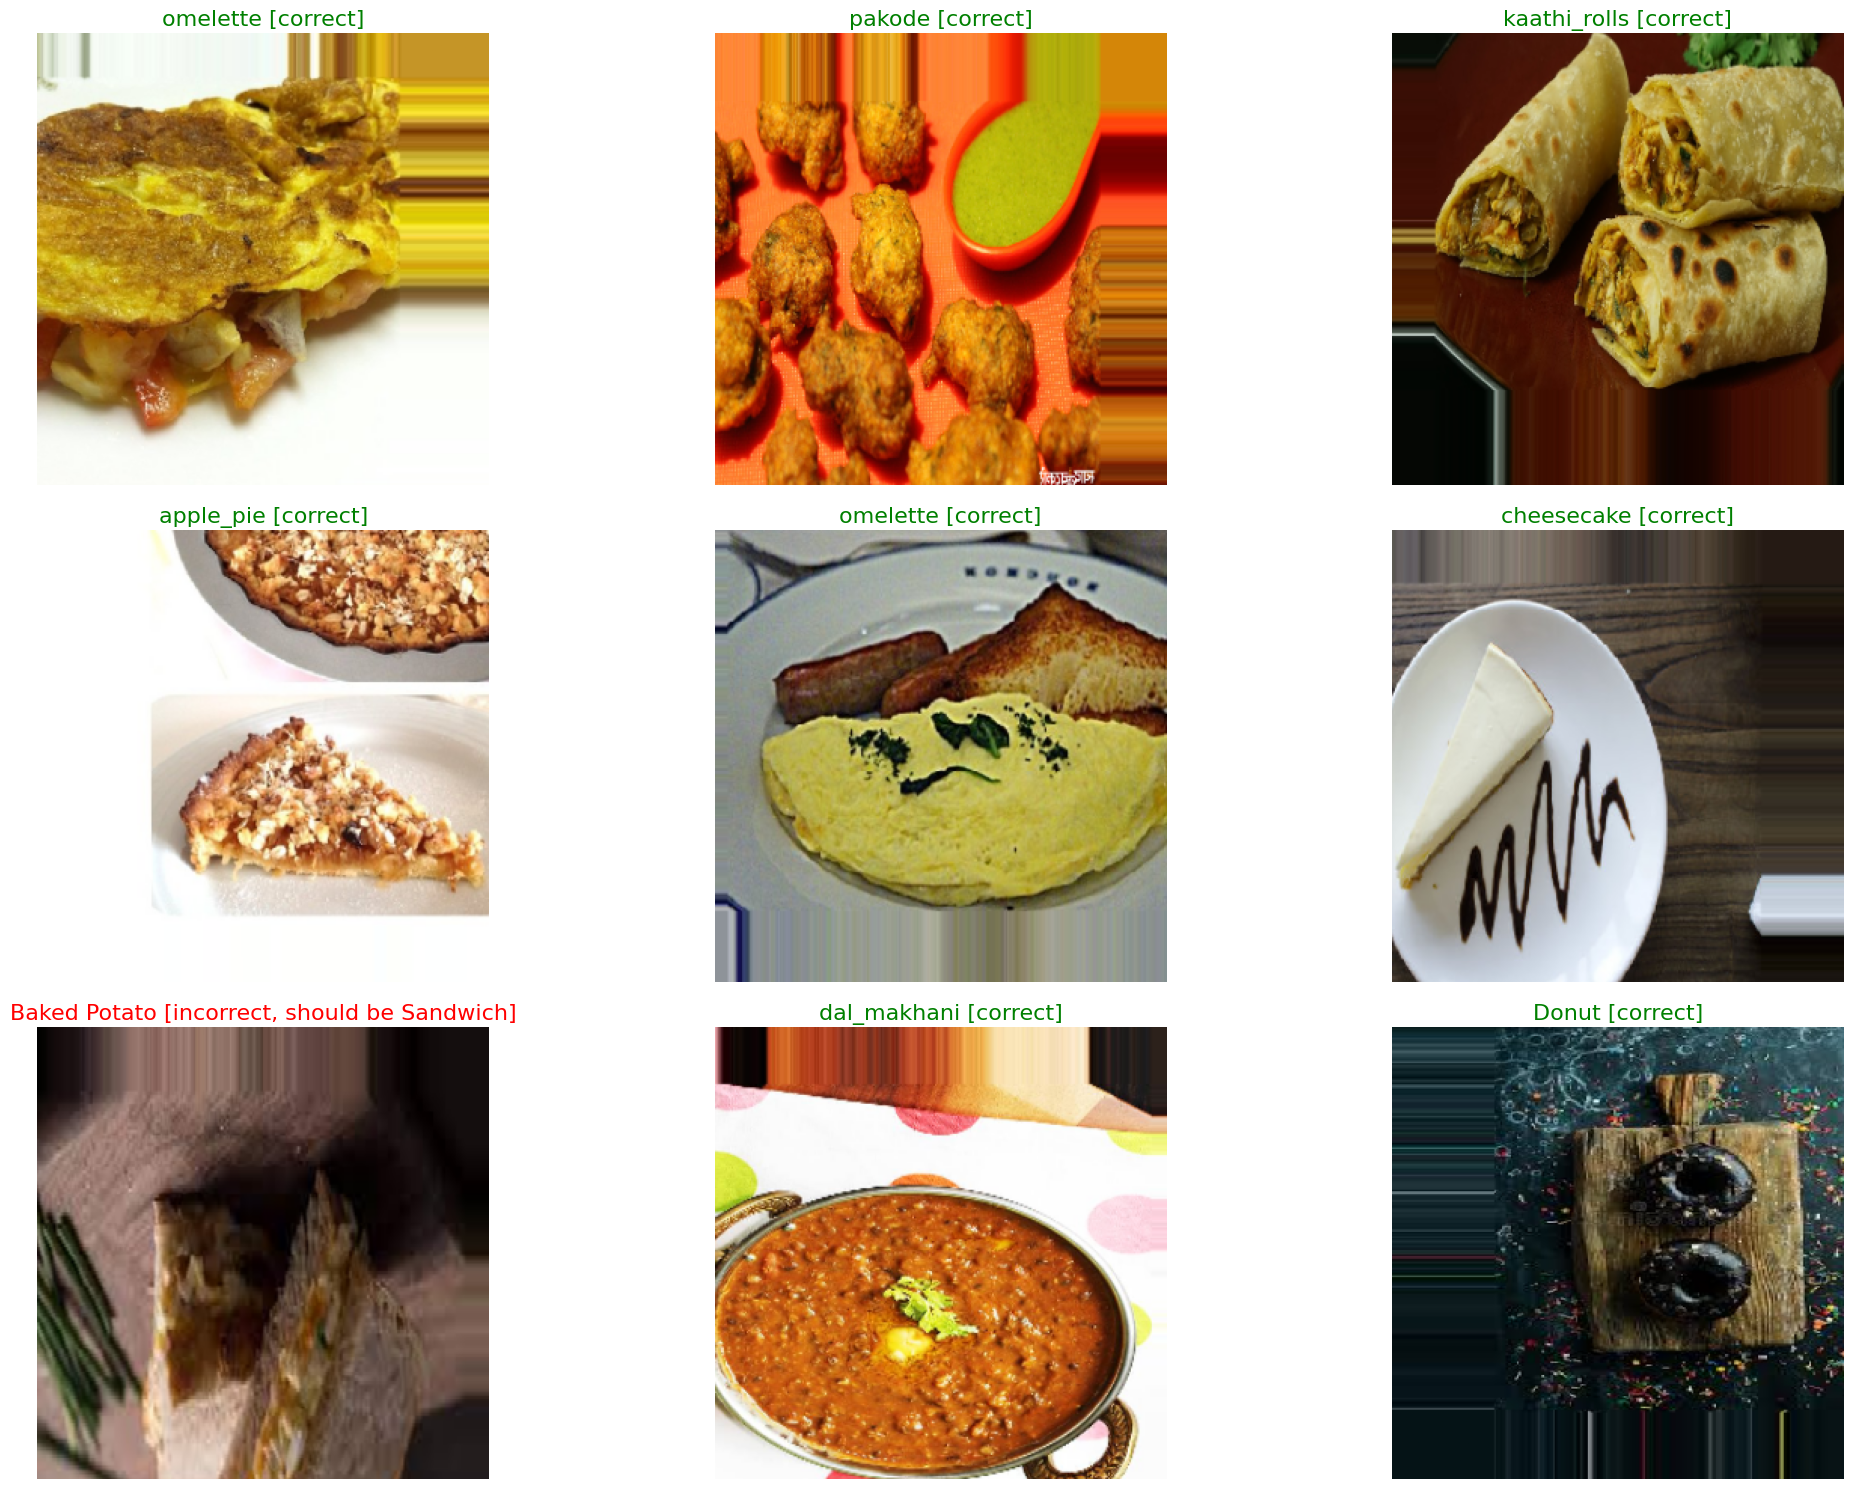

In [16]:
# displaying the predicted data of vgg19_model.
images, classes = next(validation_data)
titles, colors = get_titles(images, classes, vgg19_model)
display_nine_foods(images, titles, colors)

In [19]:
# defining function to display confusion matrix and calssification report.

import seaborn as sns
def evaluate_and_plot_confusion_matrix(model, generator):
    # Generate predictions
    y_pred = model.predict(generator)

    # Convert predictions to class labels
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Convert true labels to class labels
    y_true_classes = generator.classes

    # Get class labels
    class_labels = list(generator.class_indices.keys())

    # Calculate confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(18, 26))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Display classification report
    print('\nClassification Report:\n', classification_report(y_true_classes, y_pred_classes, target_names=class_labels))


In [ ]:
#plotting confusion matrix and calssifiaction report of  model
evaluate_and_plot_confusion_matrix(vgg19_model, validation_data)

32/77 [===========>..................] - ETA: 1:22